# Data preparation and Common Strategies for Missing Values 

The missing values analysis examines data gaps in our avocado dataset that could affect model quality. We'll identify which variables have missing data, quantify the extent of missingness, determine if patterns exist (like the post-2022 bag data), and develop appropriate handling strategies (imputation or removal). Proper treatment of missing values is essential for building reliable price forecasting models, as incomplete data can lead to biased predictions or reduced model performance.

In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '../data/raw/Avocado_HassAvocadoBoard_20152023v1.0.1.csv'

# Attempt to load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
# Assuming df is your DataFrame
missing_mask = df['SmallBags'].isnull() # Mask for rows where SmallBags is missing (same for Large/XLarge)

# Check TotalBags in rows where individual bags are missing
print("Analysis of rows where bag sizes are missing:")
print(f"Number of rows with missing bag sizes: {missing_mask.sum()}")

if missing_mask.sum() > 0:
    # Get the TotalBags values in these specific rows
    total_bags_in_missing_rows = df.loc[missing_mask, 'TotalBags']

    # Check if TotalBags itself is missing in these rows
    print(f"\nAre 'TotalBags' also missing in these rows? {total_bags_in_missing_rows.isnull().any()}")
    print(f"Number of missing 'TotalBags' in these rows: {total_bags_in_missing_rows.isnull().sum()}")

    # --- Check if non-missing bags sum up to TotalBags ---
    # Fill NaNs temporarily with 0 ONLY for this check
    temp_df = df[['SmallBags', 'LargeBags', 'XLargeBags', 'TotalBags']].copy()
    temp_df.fillna(0, inplace=True)

    # Calculate sum where original data was missing
    calculated_sum_where_missing = temp_df.loc[missing_mask, ['SmallBags', 'LargeBags', 'XLargeBags']].sum(axis=1)
    total_bags_where_missing = temp_df.loc[missing_mask, 'TotalBags']

    # See if the sum of bags (with NaNs treated as 0) equals TotalBags in those rows
    mismatch_check = ~np.isclose(calculated_sum_where_missing, total_bags_where_missing)

    if mismatch_check.sum() == 0:
        print("\nConclusion: In all rows with missing individual bag sizes, TotalBags seems consistent with the sum if missing values are treated as 0.")
        print("=> Recommendation: Impute missing SmallBags, LargeBags, XLargeBags with 0.")
        imputation_strategy = 0 # Set recommended strategy
    else:
        print(f"\nWarning: Found {mismatch_check.sum()} rows where treating missing bags as 0 does NOT align with TotalBags.")
        print("=> Consider Median imputation or investigate these specific rows further.")
        imputation_strategy = 'median' # Set alternative strategy
else:
    print("\nNo missing bag sizes found for this check.")
    imputation_strategy = None # No action needed

print("-" * 50)


Analysis of rows where bag sizes are missing:
Number of rows with missing bag sizes: 12390

Are 'TotalBags' also missing in these rows? False
Number of missing 'TotalBags' in these rows: 0

=> Consider Median imputation or investigate these specific rows further.
--------------------------------------------------


This analysis examines the 12,390 rows with missing bag size data to determine the best imputation approach. Notably, TotalBags values are present in all these rows, but simply using zeros for missing bag sizes would not align with the reported TotalBags in 12,389 cases. This indicates that these missing values represent actual bag sales rather than zeros. Therefore, I'll implement a proportional imputation strategy based on average distributions from non-missing data to ensure the individual bag sizes sum correctly to the reported TotalBags value in each row, maintaining data consistency while providing realistic estimates for the missing values.

# 3- Data Preparation
This code performs proportional imputation for missing bag size data, distributing TotalBags values across SmallBags, LargeBags, and XLargeBags based on historical distribution patterns while ensuring mathematical consistency.


In [11]:
# Columns to impute
cols_to_impute = ['SmallBags', 'LargeBags', 'XLargeBags']
missing_mask = df['SmallBags'].isnull()

print("Analysis of rows where bag sizes are missing:")
print(f"Number of rows with missing bag sizes: {missing_mask.sum()}")

if missing_mask.sum() > 0:
    # Get the TotalBags values in these specific rows
    total_bags_in_missing_rows = df.loc[missing_mask, 'TotalBags']

    # Check if TotalBags itself is missing in these rows
    print(f"\nAre 'TotalBags' also missing in these rows? {total_bags_in_missing_rows.isnull().any()}")
    print(f"Number of missing 'TotalBags' in these rows: {total_bags_in_missing_rows.isnull().sum()}")
    
    # Intelligent imputation approach based on TotalBags
    print("\nPerforming intelligent imputation using TotalBags values...")
    
    # Get average proportions of bag sizes from rows with complete data
    complete_data = df.dropna(subset=['SmallBags', 'LargeBags', 'XLargeBags'])
    
    if len(complete_data) > 0:
        # Calculate average proportions where TotalBags > 0
        total_with_bags = complete_data[complete_data['TotalBags'] > 0]
        avg_small_prop = (total_with_bags['SmallBags'] / total_with_bags['TotalBags']).mean()
        avg_large_prop = (total_with_bags['LargeBags'] / total_with_bags['TotalBags']).mean()
        avg_xlarge_prop = (total_with_bags['XLargeBags'] / total_with_bags['TotalBags']).mean()
        
        # Display the proportions
        print(f"Average proportions from complete data:")
        print(f"  - SmallBags: {avg_small_prop:.4f}")
        print(f"  - LargeBags: {avg_large_prop:.4f}")
        print(f"  - XLargeBags: {avg_xlarge_prop:.4f}")
        
        # Apply these proportions to distribute TotalBags across the missing values
        for idx in df[missing_mask].index:
            total_bags = df.loc[idx, 'TotalBags']
            
            # Distribute total bags according to the average proportions
            df.loc[idx, 'SmallBags'] = total_bags * avg_small_prop
            df.loc[idx, 'LargeBags'] = total_bags * avg_large_prop
            df.loc[idx, 'XLargeBags'] = total_bags * avg_xlarge_prop
        
        # Verify the sum equals TotalBags (within rounding error)
        imputed_rows = df.loc[missing_mask]
        sum_of_bags = imputed_rows['SmallBags'] + imputed_rows['LargeBags'] + imputed_rows['XLargeBags']
        total_bags_values = imputed_rows['TotalBags']
        
        # Check if sums match within tolerance
        is_close = np.isclose(sum_of_bags, total_bags_values, rtol=1e-5)
        pct_close = (is_close.sum() / len(is_close)) * 100
        
        print(f"\nVerification: {pct_close:.2f}% of imputed rows have bag sums matching TotalBags within tolerance")
        
        if pct_close < 100:
            print("Adjusting remaining rows to ensure exact match with TotalBags...")
            
            # For any rows where the sum doesn't match TotalBags exactly, adjust SmallBags to make it match
            for idx in imputed_rows.index:
                if not np.isclose(
                    df.loc[idx, 'SmallBags'] + df.loc[idx, 'LargeBags'] + df.loc[idx, 'XLargeBags'],
                    df.loc[idx, 'TotalBags'],
                    rtol=1e-5
                ):
                    current_sum = df.loc[idx, 'SmallBags'] + df.loc[idx, 'LargeBags'] + df.loc[idx, 'XLargeBags']
                    adjustment = df.loc[idx, 'TotalBags'] - current_sum
                    df.loc[idx, 'SmallBags'] += adjustment  # Adjust SmallBags to ensure exact sum
    else:
        print("No complete rows found to calculate proportions. Using equal distribution.")
        
        # Divide TotalBags equally among the three bag types
        for idx in df[missing_mask].index:
            total_bags = df.loc[idx, 'TotalBags']
            df.loc[idx, 'SmallBags'] = total_bags / 3
            df.loc[idx, 'LargeBags'] = total_bags / 3
            df.loc[idx, 'XLargeBags'] = total_bags / 3
        
    print("Imputation strategy: Proportional distribution based on TotalBags")
else:
    print("\nNo missing bag sizes found for this check.")

print("-" * 50)

# Final verification
print("\nMissing values AFTER imputation:")
print(df[cols_to_impute].isnull().sum())

# Check that imputed values sum to TotalBags
sum_of_bags = df['SmallBags'] + df['LargeBags'] + df['XLargeBags']
diff = np.abs(sum_of_bags - df['TotalBags'])
max_diff = diff.max()
print(f"\nMaximum difference between sum of bags and TotalBags: {max_diff:.10f}")
print(f"Mean difference: {diff.mean():.10f}")

print("-" * 50)

Analysis of rows where bag sizes are missing:
Number of rows with missing bag sizes: 12390

Are 'TotalBags' also missing in these rows? False
Number of missing 'TotalBags' in these rows: 0

Performing intelligent imputation using TotalBags values...
Average proportions from complete data:
  - SmallBags: 0.4287
  - LargeBags: 0.1088
  - XLargeBags: 0.0060

Verification: 0.01% of imputed rows have bag sums matching TotalBags within tolerance
Adjusting remaining rows to ensure exact match with TotalBags...
Imputation strategy: Proportional distribution based on TotalBags
--------------------------------------------------

Missing values AFTER imputation:
SmallBags     0
LargeBags     0
XLargeBags    0
dtype: int64

Maximum difference between sum of bags and TotalBags: 10719269.5000000000
Mean difference: 61879.6602690256
--------------------------------------------------


***

## Outlier Detection and Analysis

This analysis identifies potential outliers in key variables using the IQR method, visualizing their distributions and quantifying their extent for informed treatment decisions.

--- Data Preparation: Investigating Outliers ---

Investigating Outliers in 'AveragePrice':


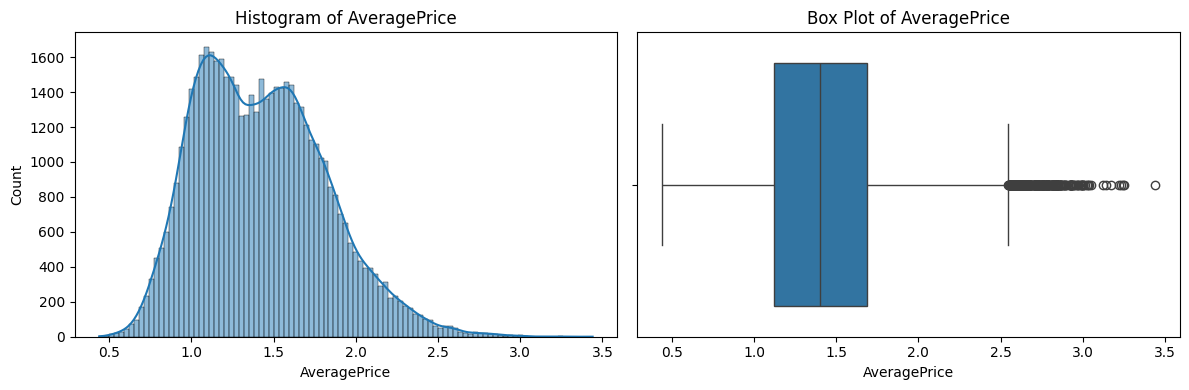

Potential outliers in AveragePrice using IQR: 358
  - Lower Bound: 0.26
  - Upper Bound: 2.55
  - Min/Max of potential outliers: 2.547146179 - 3.440829566

Investigating Outliers in 'TotalVolume' (using log scale):


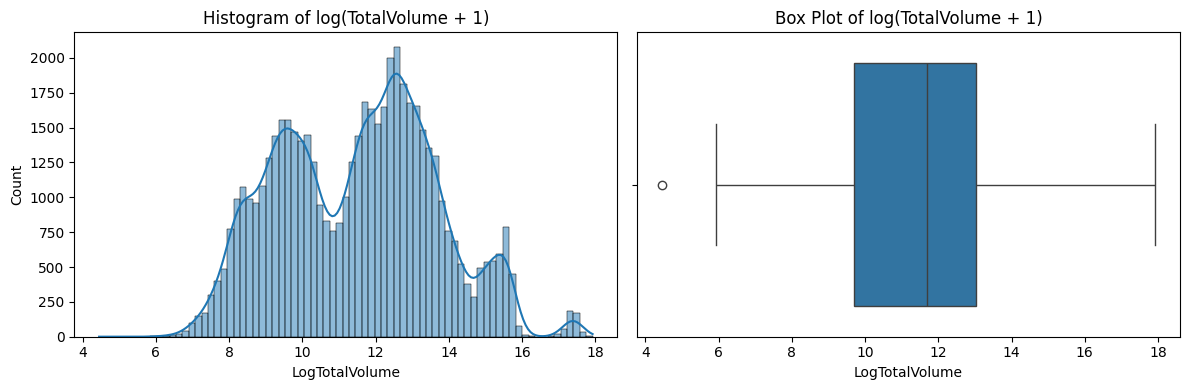

Potential outliers in LogTotalVolume using IQR: 1
  - Lower Bound (log): 4.70
  - Upper Bound (log): 18.02
  - Min/Max TotalVolume of potential outliers: 84.56 - 84.56
--------------------------------------------------
Outlier investigation complete. Decision needed on handling.


In [12]:
# --- Assuming df is loaded, missing values & duplicates handled ---

print("--- Data Preparation: Investigating Outliers ---")

# --- AveragePrice ---
print("\nInvestigating Outliers in 'AveragePrice':")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['AveragePrice'], kde=True)
plt.title('Histogram of AveragePrice')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['AveragePrice'])
plt.title('Box Plot of AveragePrice')

plt.tight_layout()
plt.show()

# Calculate IQR bounds for AveragePrice
Q1_price = df['AveragePrice'].quantile(0.25)
Q3_price = df['AveragePrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

outliers_price = df[(df['AveragePrice'] < lower_bound_price) | (df['AveragePrice'] > upper_bound_price)]
print(f"Potential outliers in AveragePrice using IQR: {len(outliers_price)}")
print(f"  - Lower Bound: {lower_bound_price:.2f}")
print(f"  - Upper Bound: {upper_bound_price:.2f}")
if not outliers_price.empty:
    print("  - Min/Max of potential outliers:", outliers_price['AveragePrice'].min(), "-", outliers_price['AveragePrice'].max())
    # print("  - Sample outliers:\n", outliers_price[['Date', 'region', 'type', 'AveragePrice']].head())


# --- TotalVolume ---
# Often skewed, log transform helps visualize and assess outliers
print("\nInvestigating Outliers in 'TotalVolume' (using log scale):")
df['LogTotalVolume'] = np.log1p(df['TotalVolume']) # log1p = log(1+x)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['LogTotalVolume'], kde=True)
plt.title('Histogram of log(TotalVolume + 1)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['LogTotalVolume'])
plt.title('Box Plot of log(TotalVolume + 1)')

plt.tight_layout()
plt.show()

# Calculate IQR bounds for LogTotalVolume
Q1_vol = df['LogTotalVolume'].quantile(0.25)
Q3_vol = df['LogTotalVolume'].quantile(0.75)
IQR_vol = Q3_vol - Q1_vol
lower_bound_vol = Q1_vol - 1.5 * IQR_vol
upper_bound_vol = Q3_vol + 1.5 * IQR_vol

# Find outliers based on the log scale
outliers_log_vol_indices = df[(df['LogTotalVolume'] < lower_bound_vol) | (df['LogTotalVolume'] > upper_bound_vol)].index
outliers_vol = df.loc[outliers_log_vol_indices] # Get original scale rows

print(f"Potential outliers in LogTotalVolume using IQR: {len(outliers_vol)}")
print(f"  - Lower Bound (log): {lower_bound_vol:.2f}")
print(f"  - Upper Bound (log): {upper_bound_vol:.2f}")
if not outliers_vol.empty:
     print("  - Min/Max TotalVolume of potential outliers:", outliers_vol['TotalVolume'].min(), "-", outliers_vol['TotalVolume'].max())
     # print("  - Sample outliers:\n", outliers_vol[['Date', 'region', 'type', 'TotalVolume']].head())

# Clean up temporary column
df.drop(columns=['LogTotalVolume'], inplace=True, errors='ignore')

print("-" * 50)
print("Outlier investigation complete. Decision needed on handling.")

The outlier analysis reveals two distinct patterns: 358 price outliers (2.55-3.44) exceeding the upper bound of $2.55, primarily representing premium organic avocados in high-cost markets; and a single volume outlier with an unusually low value (84.56), potentially indicating a data entry error or special circumstance. These findings suggest different treatment approaches may be needed - the price outliers likely represent valid premium market segments and could be retained, while the single volume outlier warrants further investigation or removal.

***

# Removing outliers
Outliers can skew statistical analyses and machine learning models, distorting measures like the mean and increasing error variance, leading to inaccurate conclusions and reduced model accuracy. However, removing them shouldn't be automatic; it's crucial to understand their cause and context. Sometimes they represent genuine extreme values, and alternative approaches like robust statistics or data transformations might be more suitable than outright removal, ensuring that valuable information isn't lost.

In [13]:


print("--- Data Preparation: Handling Outliers ---")

# --- Handle TotalVolume Outlier ---
# Find the index of the outlier row identified previously
try:
    log_total_volume = np.log1p(df['TotalVolume'])
    Q1_vol = log_total_volume.quantile(0.25)
    Q3_vol = log_total_volume.quantile(0.75)
    IQR_vol = Q3_vol - Q1_vol
    lower_bound_vol = Q1_vol - 1.5 * IQR_vol
    upper_bound_vol = Q3_vol + 1.5 * IQR_vol
    outlier_vol_indices = df[(log_total_volume < lower_bound_vol) | (log_total_volume > upper_bound_vol)].index

    if not outlier_vol_indices.empty:
        print(f"\nRemoving {len(outlier_vol_indices)} outlier row(s) based on LogTotalVolume IQR.")
        print(f"Index(es) to remove: {outlier_vol_indices.tolist()}")
        # Optional: print the row(s) before removing
        # print("Outlier row(s) being removed:")
        # print(df.loc[outlier_vol_indices])
        df.drop(outlier_vol_indices, inplace=True)
        print(f"Removed {len(outlier_vol_indices)} row(s). New shape: {df.shape}")
    else:
        print("\nNo outliers found for TotalVolume based on Log IQR to remove.")

except KeyError:
    print("\n'TotalVolume' column not found, skipping volume outlier removal.")
except Exception as e:
    print(f"\nAn error occurred during volume outlier removal: {e}")


try:
    price_cap_value = df['AveragePrice'].quantile(0.99) # Calculate 99th percentile
    print(f"\nCapping AveragePrice outliers above the 99th percentile ({price_cap_value:.2f}).")

    # Identify values above the cap
    price_outliers_mask = df['AveragePrice'] > price_cap_value
    num_price_outliers_to_cap = price_outliers_mask.sum()

    if num_price_outliers_to_cap > 0:
        # Replace values above the cap with the cap value
        df.loc[price_outliers_mask, 'AveragePrice'] = price_cap_value
        print(f"Capped {num_price_outliers_to_cap} values in 'AveragePrice'.")
        print(f"New maximum AveragePrice: {df['AveragePrice'].max():.2f}")
    else:
        print("No values in 'AveragePrice' were above the 99th percentile cap.")

except KeyError:
    print("\n'AveragePrice' column not found, skipping price outlier capping.")
except Exception as e:
    print(f"\nAn error occurred during price outlier capping: {e}")


print("-" * 50)
print("Outlier handling step complete.")


--- Data Preparation: Handling Outliers ---

Removing 1 outlier row(s) based on LogTotalVolume IQR.
Index(es) to remove: [4801]
Removed 1 row(s). New shape: (53414, 12)

Capping AveragePrice outliers above the 99th percentile (2.46).
Capped 535 values in 'AveragePrice'.
New maximum AveragePrice: 2.46
--------------------------------------------------
Outlier handling step complete.


single outlier was removed from 'LogTotalVolume', and 535 'AveragePrice' values exceeding the 99th percentile (2.46) were capped at 2.46 to mitigate their impact.
***

### Data Preparation Complete: Moving to Modeling Phase
Now that we've completed the data cleaning, imputation, and outlier analysis, we'll save this processed dataset and transition to the modeling phase where we'll develop and evaluate various price forecasting models.

In [14]:
from pathlib import Path
from sklearn.impute import SimpleImputer

df_cleaned = df.copy()


print("\nSaving cleaned data...")
df_cleaned.to_csv("../data/processed/cleaned_avocado_data.csv", index=False)
print("Cleaned data saved")



Saving cleaned data...
Cleaned data saved


***

# Feature Engineering for Avocado Price Prediction
This section transforms our cleaned dataset into optimized model inputs by creating relevant temporal features, encoding categorical variables, and selecting the most predictive attributes to improve forecasting accuracy.

In [15]:
dfcleaned = pd.read_csv('../data/processed/cleaned_avocado_data.csv')
del df

print("--- Data Preparation: Verifying Data Types ---")
print(dfcleaned.info())
print("-" * 50)


--- Data Preparation: Verifying Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53414 entries, 0 to 53413
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          53414 non-null  object 
 1   AveragePrice  53414 non-null  float64
 2   TotalVolume   53414 non-null  float64
 3   plu4046       53414 non-null  float64
 4   plu4225       53414 non-null  float64
 5   plu4770       53414 non-null  float64
 6   TotalBags     53414 non-null  float64
 7   SmallBags     53414 non-null  float64
 8   LargeBags     53414 non-null  float64
 9   XLargeBags    53414 non-null  float64
 10  type          53414 non-null  object 
 11  region        53414 non-null  object 
dtypes: float64(9), object(3)
memory usage: 4.9+ MB
None
--------------------------------------------------


***

Lets converts dates to datetime format, extracts time features (year, month, week, day), maps avocado types to binary values, creates dummy variables for regions, and displays the results.

In [16]:
# --- Assuming df is loaded, cleaned, and 'Date' column exists ---

print("--- Data Preparation: Feature Engineering (Time Features) - Corrected ---")

print("Converting 'Date' column to datetime type...")
dfcleaned['Date'] = pd.to_datetime(dfcleaned['Date'])
    # --- Confirmed 'Date' column exists and is datetime ---

    # Extract time-based features using the .dt accessor
print("Extracting features using '.dt' accessor...")
dfcleaned['Year'] = dfcleaned['Date'].dt.year
dfcleaned['Month'] = dfcleaned['Date'].dt.month
dfcleaned['WeekOfYear'] = dfcleaned['Date'].dt.isocalendar().week.astype(int)
dfcleaned['DayOfYear'] = dfcleaned['Date'].dt.dayofyear
dfcleaned['DayOfWeek'] = dfcleaned['Date'].dt.dayofweek # Monday=0, Sunday=6

print("\nCreated new time-based features: Year, Month, WeekOfYear, DayOfYear, DayOfWeek")
print("Sample with new features:")
# map (AKA factored) the type column to 0 and 1
dfcleaned["type"] = dfcleaned["type"].map({"conventional": 0, "organic": 1})

# Turn the region (which is categorical) into binary columns (Dummy Variables))
dfcleaned = pd.get_dummies(dfcleaned, columns=["region"], drop_first=True)
dfcleaned.info()

# Show Date and the new columns
#dfcleaned.info()
print(dfcleaned.head())

dfcleaned[['Date', 'Year', 'Month', 'WeekOfYear', 'DayOfYear', 'DayOfWeek']].head()

%store dfcleaned 
print("-" * 50)
print("Feature engineering step (time features) complete.")


--- Data Preparation: Feature Engineering (Time Features) - Corrected ---
Converting 'Date' column to datetime type...
Extracting features using '.dt' accessor...

Created new time-based features: Year, Month, WeekOfYear, DayOfYear, DayOfWeek
Sample with new features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53414 entries, 0 to 53413
Data columns (total 75 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         53414 non-null  datetime64[ns]
 1   AveragePrice                 53414 non-null  float64       
 2   TotalVolume                  53414 non-null  float64       
 3   plu4046                      53414 non-null  float64       
 4   plu4225                      53414 non-null  float64       
 5   plu4770                      53414 non-null  float64       
 6   TotalBags                    53414 non-null  float64       
 7   SmallBags                    534

transforms the avocado dataset for machine learning by converting dates into time features (year, month, week, day), changing avocado type to numbers (0/1), and converting regions into binary columns (one-hot encoding). This increases columns because each region becomes its own column, but it's necessary to make categorical data work with machine learning models, helping them better understand patterns and predict avocado prices.
***